# Прогнозирование вероятности оттока пользователей для фитнес-центров

## Шаг 1. Обзор данных

In [2]:
# выгрузка необходимых библиотек для работы с данными
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools
import warnings

In [3]:
# загрузка данных клиента на месяц до оттока и факт оттока на определённый месяц
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

# просмотр информации о таблице gym_churn
gym_churn.info()

# просмотр таблицы gym_churn
display(gym_churn.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Описание данных таблицы `gym_churn`:**
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

В названиях столбцов обнаружено нарушение стиля:
- Строчные буквы сочетаются с прописными.

Далее названия столбцов будут приведены к нужному стилю, будет проведена проверка на наличие дубликатов и пропусков в данных.

## Шаг 2. Предобработка данных

### Стиль заголовков

In [4]:
# приведение названий столбцов к нужным регистрам в таблице
gym_churn.columns = [x.lower() for x in gym_churn.columns]
print(gym_churn.columns)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')


### Дубликаты

In [5]:
# проверка на наличие явных дубликатов
print(gym_churn.duplicated().sum())

0


In [8]:
# функция для проверки на наличие неявных дубликатов
def dup(column, n=5):
    res_1 = gym_churn[column].unique()
    res_2 = gym_churn[column].value_counts().head(n)
    print('*'*50)
    return res_1, res_2

In [9]:
for col in gym_churn.columns:
    display(dup(col, n=5))

**************************************************


(array([1, 0]),
 1    2041
 0    1959
 Name: gender, dtype: int64)

**************************************************


(array([1, 0]),
 1    3381
 0     619
 Name: near_location, dtype: int64)

**************************************************


(array([1, 0]),
 0    2053
 1    1947
 Name: partner, dtype: int64)

**************************************************


(array([1, 0]),
 0    2766
 1    1234
 Name: promo_friends, dtype: int64)

**************************************************


(array([0, 1]),
 1    3614
 0     386
 Name: phone, dtype: int64)

**************************************************


(array([ 6, 12,  1]),
 1     2207
 12     960
 6      833
 Name: contract_period, dtype: int64)

**************************************************


(array([1, 0]),
 0    2351
 1    1649
 Name: group_visits, dtype: int64)

**************************************************


(array([29, 31, 28, 33, 26, 34, 32, 30, 23, 27, 35, 25, 36, 24, 21, 37, 22,
        19, 20, 38, 39, 18, 41]),
 29    468
 30    457
 28    447
 31    434
 27    378
 Name: age, dtype: int64)

**************************************************


(array([ 14.22747042, 113.20293765, 129.44847933, ...,  78.25054157,
         61.91265691, 178.86181361]),
 89.952762     1
 174.658455    1
 122.765563    1
 204.444527    1
 50.813166     1
 Name: avg_additional_charges_total, dtype: int64)

**************************************************


(array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.]),
 1.0     2207
 6.0      645
 12.0     524
 11.0     181
 5.0      130
 Name: month_to_end_contract, dtype: int64)

**************************************************


(array([ 3,  7,  2,  0,  1, 11,  4,  8, 14,  6,  5, 15, 12, 21, 10, 20,  9,
        13, 17, 16, 24, 22, 31, 26, 23, 18, 19, 27, 29]),
 1    843
 2    610
 3    490
 0    487
 4    383
 Name: lifetime, dtype: int64)

**************************************************


(array([0.02039795, 1.92293606, 1.85909835, ..., 2.78614636, 1.63010814,
        1.10183221]),
 0.000000    88
 0.827058     1
 2.770845     1
 1.472779     1
 3.735185     1
 Name: avg_class_frequency_total, dtype: int64)

**************************************************


(array([0.        , 1.91024352, 1.73650189, ..., 2.8314395 , 1.59623664,
        1.03526976]),
 0.000000    181
 0.379235      1
 0.054540      1
 1.877288      1
 1.058906      1
 Name: avg_class_frequency_current_month, dtype: int64)

**************************************************


(array([0, 1]),
 0    2939
 1    1061
 Name: churn, dtype: int64)

### Пропуски

In [10]:
# подсчет пропущенных значений
print(gym_churn.isna().sum())

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64


**Вывод:**

При предобработке данных было обнаружено и исправлено:

* Нарушение стиля в названиях столбцов - все названия столбцов были приведены к общему (нижнему) регистру;

Пропусков и дубликатов (явных, неявных) в данных не обнаружено.

## Шаг 3. Исследовательский анализ данных (EDA)

In [11]:
# просмотр таблицы, информации и размера
display(gym_churn.head())
gym_churn.info()
print(gym_churn.shape)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

В датафрейме 4000 наблюдений и 14 полей - 13 признаков и целевая переменная (`churn`). Признаки - численные.

In [14]:
# функция для просмотра describe()
def desc(col):
    print(gym_churn[col].describe())
    print('*'*50)
    return

In [15]:
# describe() для всех столбцов
for col in gym_churn.columns:
    desc(col)

count    4000.000000
mean        0.510250
std         0.499957
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64
**************************************************
count    4000.000000
mean        0.845250
std         0.361711
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: near_location, dtype: float64
**************************************************
count    4000.000000
mean        0.486750
std         0.499887
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: partner, dtype: float64
**************************************************
count    4000.000000
mean        0.308500
std         0.461932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: promo_friends, dtype: float64
********************************************

In [16]:
# средние значения признаков в двух группах (отток и неотток)
churn_gr = gym_churn.groupby('churn').agg('mean')
display(churn_gr)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Распределение на отток и неотток по средним значениям для признаков:
- `gender` - пол равномерно распределен на отток и неотток;
- `near_location` - факт проживания или работа в районе, где находится фитнес-центр, влияет на меньший отток;
- `partner` - отсутствие факта сотрудничества компании-партнёра клуба дает больший отток;
- `promo_friends` - факт первоначальной записи в рамках акции «приведи друга» приводит к меньшему оттоку;
- `phone` - факт наличия контактного телефона равномерно распределен на отток и неотток;
- `contract_period` - длительность текущего действующего абонемента менее 2-х месяцев дает больший отток, более 5-6 месяцев дает меньший отток;
- `group_visits` - факт посещения групповых занятий приводит к меньшему оттоку;
- `age` - больший отток клиентов в возрасте до 27 лет;
- `avg_additional_charges_total` - случай, когда суммарная выручка от других услуг фитнес-центра составляет менее 115 тыс. р. приводит к большиму оттоку;
- `month_to_end_contract` - в случае длительности текущего действующего абонемента менее 2-х месяцев дает больший отток;
- `lifetime` - в случае, когда с момента первого обращения в фитнес-центр прошло менее 1-го месяца приводит к большему оттоку;
- `avg_class_frequency_total` - в случае, когда средняя частота посещений в неделю за все время с начала действия абонемента составляет менее 2-х раз приводит к большему оттоку;
- `avg_class_frequency_current_month` - в случае, когда средняя частота посещений в неделю за предыдущий месяц составляет менее 1-го раза больший приводит к большему оттоку.

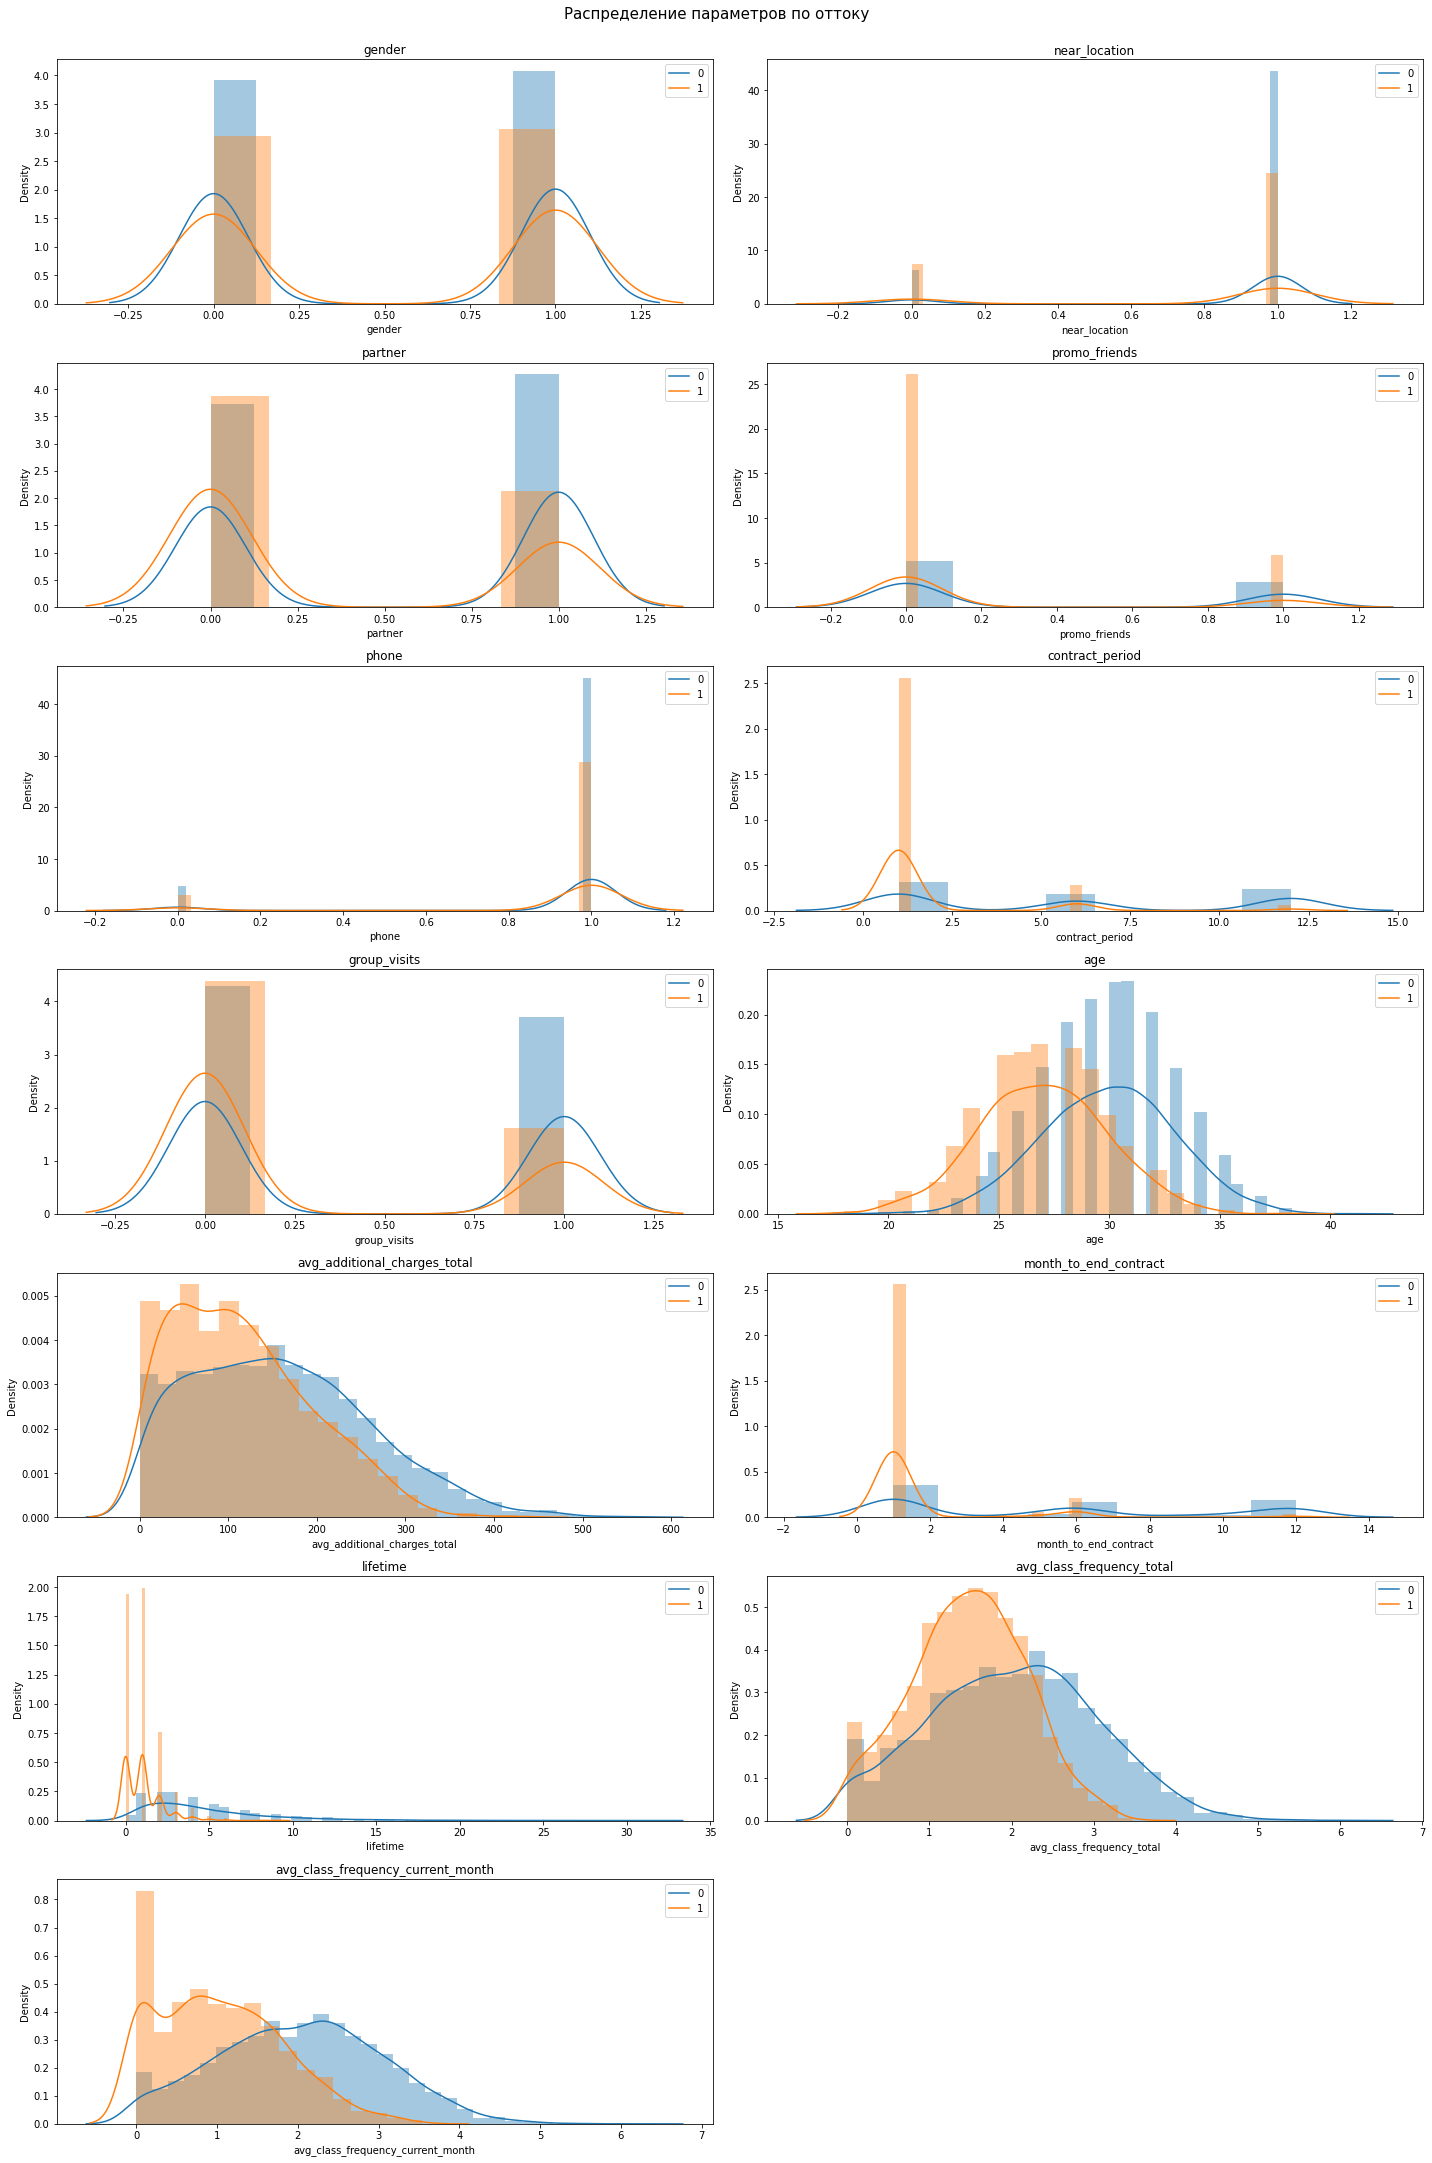

In [17]:
# для того чтобы предупреждение не мешало
warnings.filterwarnings('ignore')

research = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age',
            'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
           'avg_class_frequency_current_month']

# число рядов и столбцов в сетке графиков
col_count, row_count = 2, 7

# размер графиков
plt.figure(figsize = (20, 30))

# положение графиков в сетке, i+1 порядковый номер графика
for i, j in enumerate(research):
    for churn in gym_churn['churn'].unique():
        current = gym_churn.query('churn == @churn')
        sns.distplot(current[j], ax = plt.subplot(row_count, col_count, i+1))
    
    # добавление подзаголовков на каждый график
    plt.title(j)
    
    # добавление легенды на каждый график
    plt.legend(labels=gym_churn['churn'].unique())

# название
plt.suptitle('Распределение параметров по оттоку', y = 1, fontsize = 15)

# настройка подзаголовков
plt.tight_layout()

plt.show()

Исходя из графиков, можно сказать, что на отток оказывают большее влияние такие признаки: 
- `near_location` - больший отток в случае не проживания или работы в районе, где находится фитнес-центр;
- `partner` - больший отток в случае, если это не сотрудник компании-партнёра клуба;
- `promo_friends` - больший отток в случае отсутствия факта первоначальной записи в рамках акции «приведи друга»;
- `contract_period` - больший отток в случае длительности текущего действующего абонемента месяц и 6 месяцев;
- `group_visits` - больший отток в случае отсутсвия факта посещения групповых занятий;
- `age` - больший отток клиентов в возрасте до 30 лет;
- `avg_additional_charges_total` - больший отток в случае суммарной выручки от других услуг фитнес-центра составляет менее 200 тыс. р.;
- `month_to_end_contract` - больший отток в случае, когда срок до окончания текущего действующего абонемента составляет до 6 месяцев, особенно менее 2-х;
- `lifetime` - больший отток в случае, когда с момента первого обращения в фитнес-центр прошло менее 4 месяцев, особенно менее 2-х;
- `avg_class_frequency_total` - больший отток в случае, когда средняя частота посещений в неделю за все время с начала действия абонемента составляет менее 2-х раз;
- `avg_class_frequency_current_month` - больший отток в случае, когда средняя частота посещений в неделю за предыдущий месяц составляет менее 2-х раз.

Такие признаки как `gender`(пол) и `phone`(наличие контактного телефона) имеют одинаковый отток в случае клиентов разного пола, как и в случае наличия или нет контактного телефона.

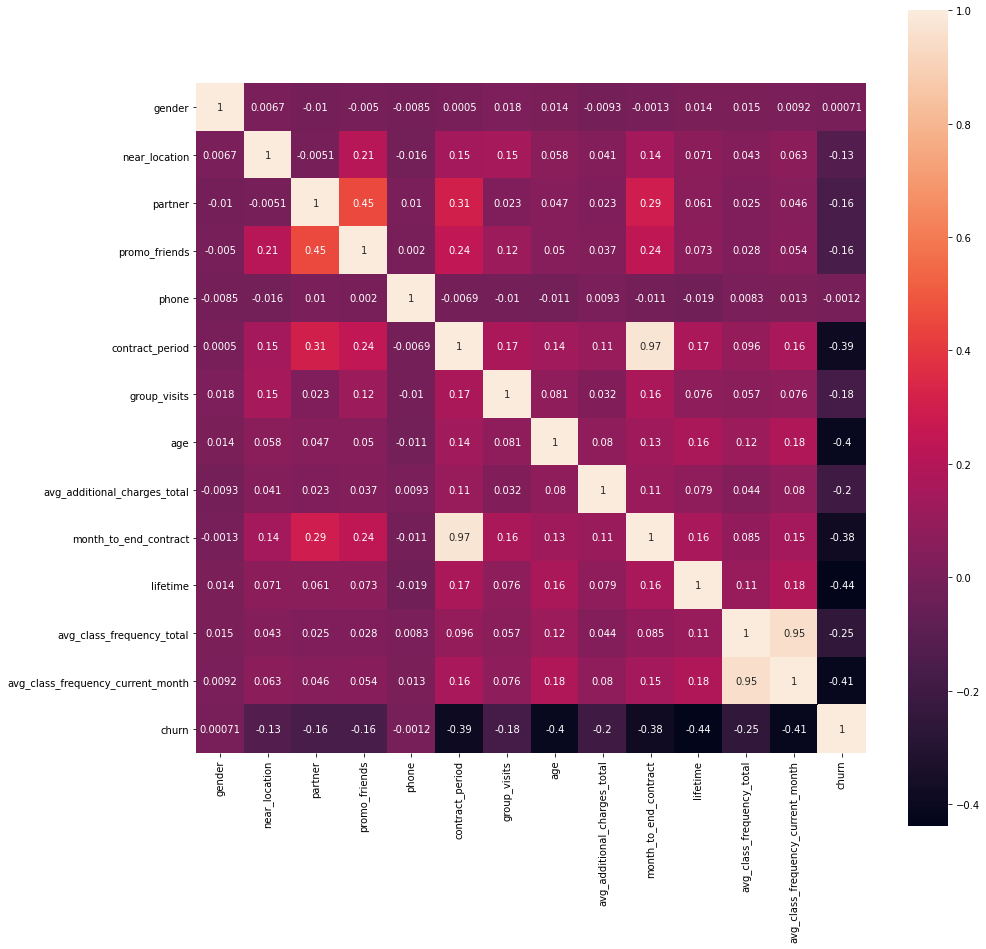

In [18]:
# матрица корреляций
cm = gym_churn.corr() # вычисление матрицы корреляций

plt.figure(figsize = (15, 15))

# тепловая карта с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True)
plt.show()

По графику матрицы корреляций заметны две пары сильно коррелирующих признаков (более 0.8), `month_to_end_contract` - `contract_period` и `avg_class_frequency_current_month` - `avg_class_frequency_total`. Далее будут удалены по одному признаку из данных двух коррелирующих пар.

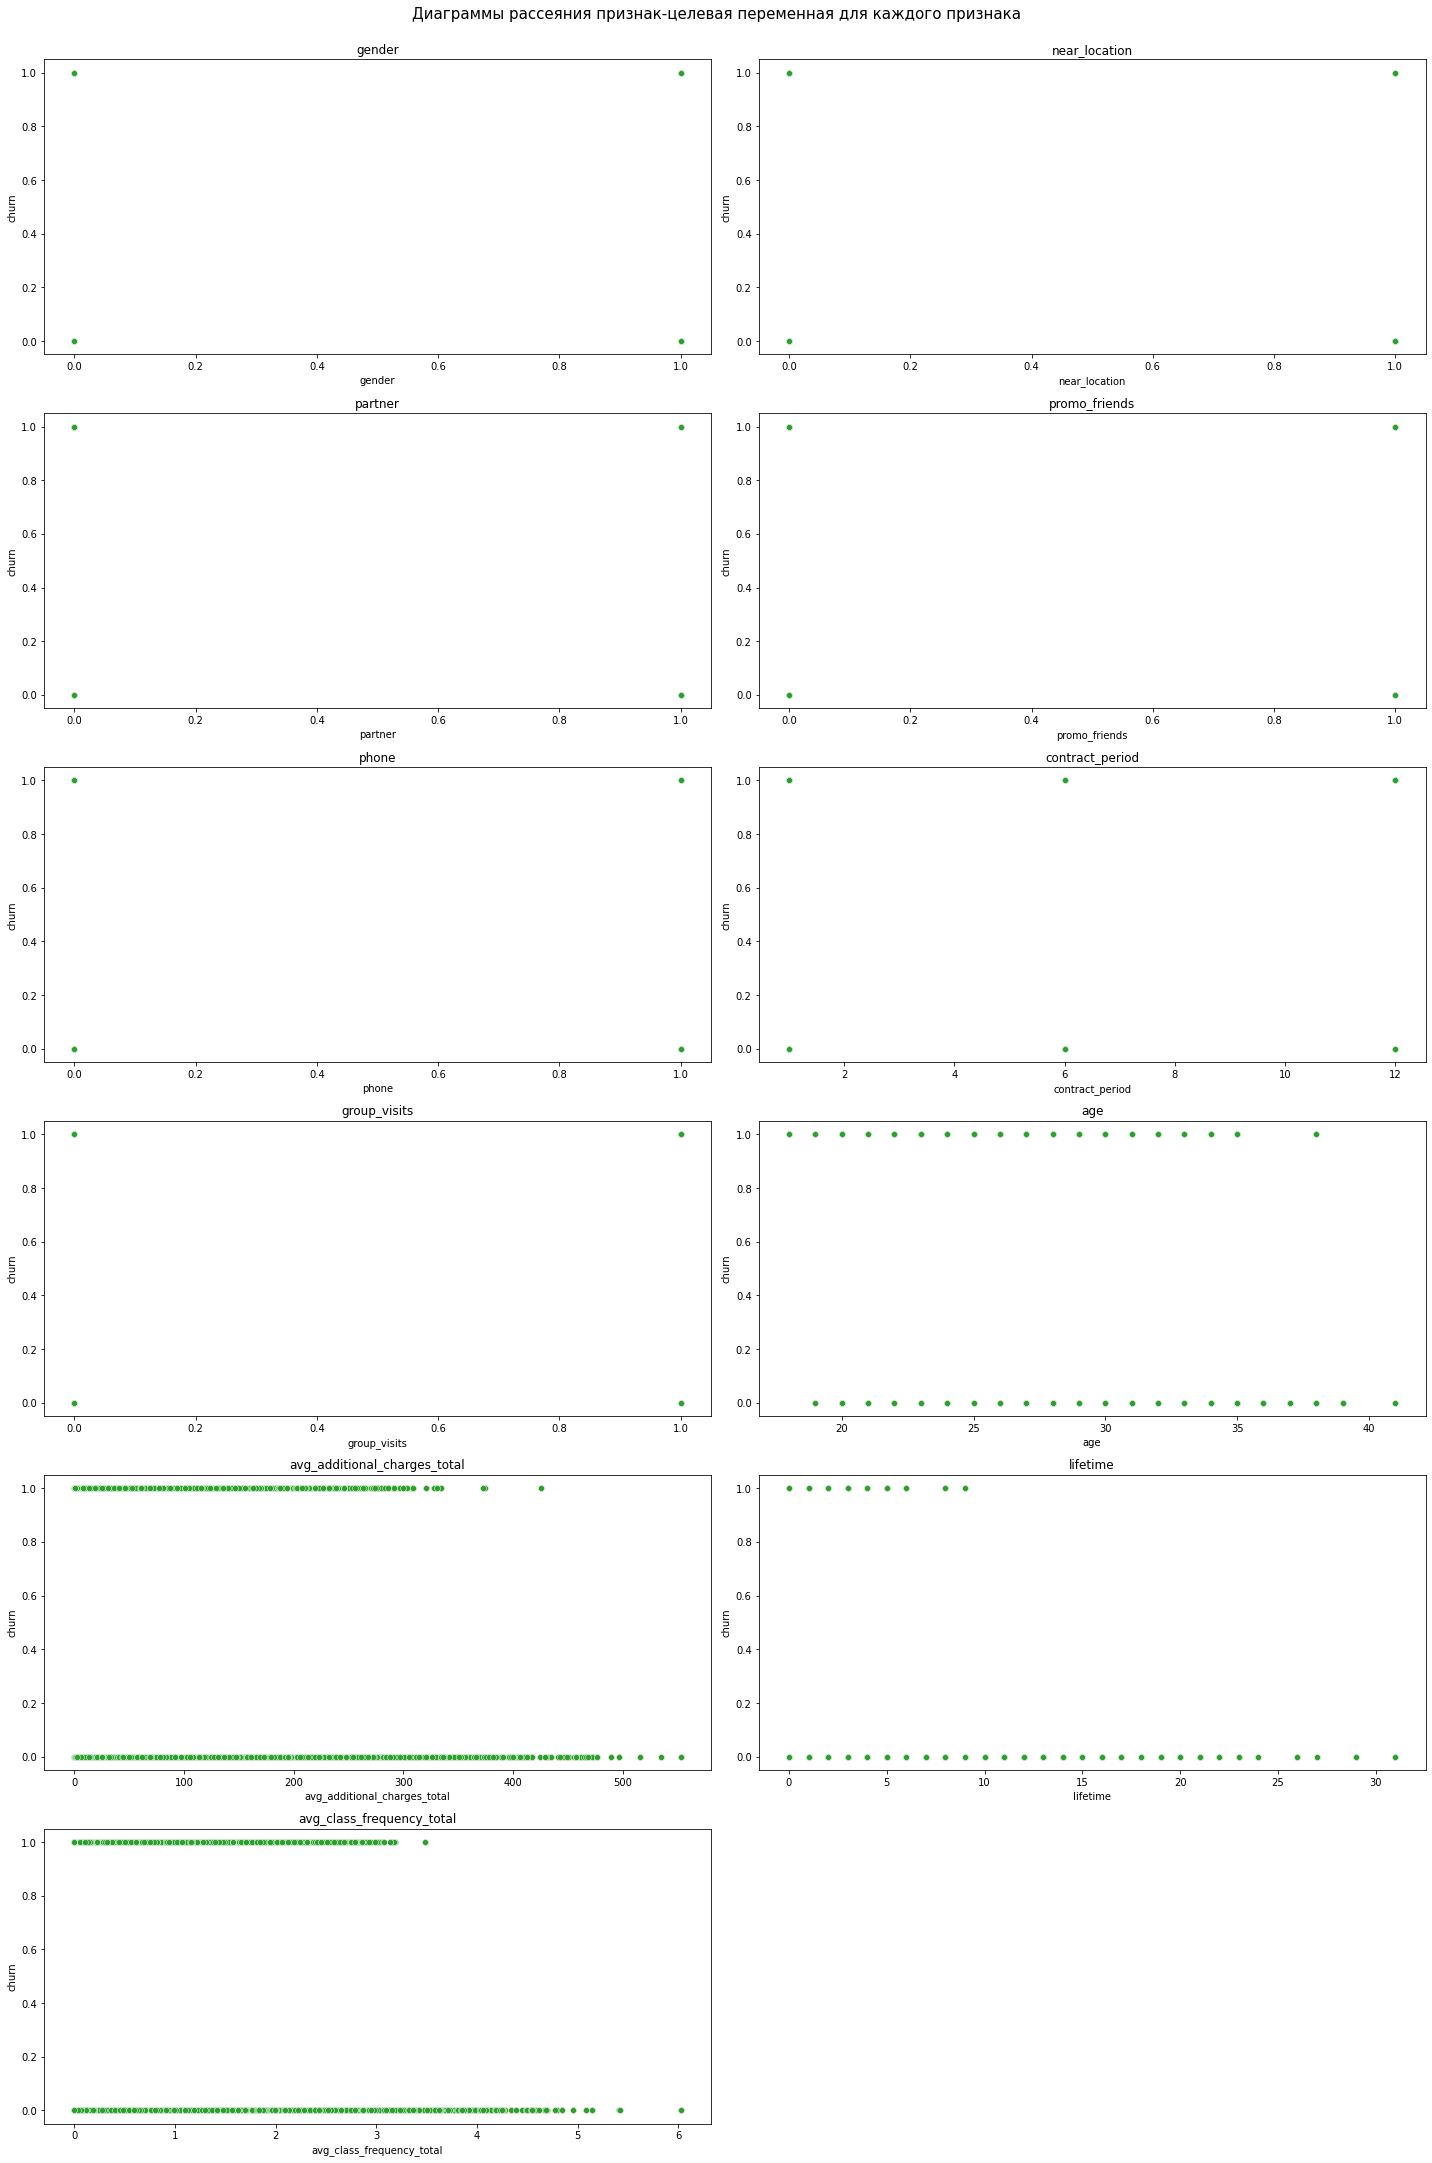

In [19]:
# попарные диаграммы рассеяния признак-целевая переменная для каждого признака
params = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age',
            'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']

# число рядов и столбцов в сетке графиков
col_count, row_count = 2, 6

# размер графиков
plt.figure(figsize = (20, 30))

# положение графиков в сетке, i+1 порядковый номер графика
for i, param in enumerate(params):
    for col in gym_churn.drop('churn', axis = 1).columns:
        sns.scatterplot(x=gym_churn[param], y=gym_churn['churn'], ax = plt.subplot(row_count, col_count, i + 1))
    plt.title(param)

# название
plt.suptitle('Диаграммы рассеяния признак-целевая переменная для каждого признака', y = 1, fontsize = 15)

# настройка подзаголовков
plt.tight_layout()
plt.show()

Ярких выбросов по диаграммам рассеяния - не наблюдается.  Перекос наблюдается в `lifetime`, но так как пропусков в данных не было и нулевые значения - реальные данные, то построение модели по ним - возможно. 

**Вывод**

В ходе исследовательского анализа данных:
- В датафрейме 4000 наблюдений и 14 полей - 13 признаков и целевая переменная (`churn`). Признаки - численные;
- При построении графиков распределения параметров по оттоку - такие признаки как `gender`(пол) и `phone`(наличие контактного телефона) имеют одинаковый отток в случае клиентов разного пола, как и в случае наличия или нет контактного телефона, остальные признаки показывают больший отток: 
    - `near_location` - в случае не проживания или работы в районе, где находится фитнес-центр;
    - `partner` - в случае, если это не сотрудник компании-партнёра клуба;
    - `promo_friends` - в случае отсутствия факта первоначальной записи в рамках акции «приведи друга»;
    - `contract_period` - в случае длительности текущего действующего абонемента месяц и 6 месяцев;
    - `group_visits` - в случае отсутсвия факта посещения групповых занятий;
    - `age` - клиентов в возрасте до 30 лет;
    - `avg_additional_charges_total` - в случае суммарной выручки от других услуг фитнес-центра составляет менее 200 тыс. р.;
    - `month_to_end_contract` - в случае, когда срок до окончания текущего действующего абонемента составляет до 6 месяцев, особенно менее 2-х;
    - `lifetime` - в случае, когда с момента первого обращения в фитнес-центр прошло менее 4 месяцев, особенно менее 2-х;
    - `avg_class_frequency_total` - в случае, когда средняя частота посещений в неделю за все время с начала действия абонемента составляет менее 2-х раз;
    - `avg_class_frequency_current_month` - в случае, когда средняя частота посещений в неделю за предыдущий месяц составляет менее 2-х раз.
- По графику матрицы корреляций заметны две пары сильно коррелирующих признаков (более 0.8), `month_to_end_contract` - `contract_period` и `avg_class_frequency_current_month` - `avg_class_frequency_total`. Далее будут удалены по одному признаку из данных двух коррелирующих пар.
- При постоении диаграммы рассеяния признак-целевая переменная для каждого признака - ярких выбросов по диаграммам рассеяния - не наблюдается.  Перекос наблюдается в `lifetime`, но так как пропусков в данных не было и нулевые значения - реальные данные, то построение модели по ним - возможно. 

## Шаг 4. Модель прогнозирования оттока клиентов

In [20]:
# изавление от мультиколлинеарности между признаками contract_period и month_to_end_contract
gym_churn.drop('month_to_end_contract', axis = 1, inplace = True)

# изавление от мультиколлинеарности между признаками avg_class_frequency_current_month и avg_class_frequency_total
gym_churn.drop('avg_class_frequency_current_month', axis = 1, inplace = True)

In [21]:
# разделение данных на признаки (матрица X) и целевую переменную (y)
x = gym_churn.drop('churn', axis = 1)
y = gym_churn['churn']

# разделение модели на обучающую и валидационную выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# создание объекта класса StandardScaler и применение его к обучающей выборке
scaler = StandardScaler()
x_train_st = scaler.fit_transform(
    x_train
)  # обучение scaler и одновременно трансформирование матрицы для обучающей выборки

# применение стандартизации к матрице признаков для тестовой выборки
x_test_st = scaler.transform(x_test)

# обучение модели методом логистической регрессии
lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model.fit(x_train_st, y_train)
lr_pred = lr_model.predict(x_test_st)

print('Результаты логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_pred)))
print('')

# обучение модели методом случайного леса
tree_model =  DecisionTreeClassifier(random_state=0)
tree_model.fit(x_train_st, y_train)
tree_pred = tree_model.predict(x_test_st)

print('Результаты случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, tree_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, tree_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, tree_pred)))

Результаты логистической регрессии
Accuracy: 0.90
Precision: 0.79
Recall: 0.81

Результаты случайного леса
Accuracy: 0.83
Precision: 0.64
Recall: 0.71


**Вывод**

На основании метрик `Accuracy`, `Precision` и `Recall` модель LogisticRegression (Логистической регресси) показывает лучшие результаты в сравнении метрик модели DecisionTreeClassifier (Случайного леса).

## Шаг 5. Кластеризация клиентов

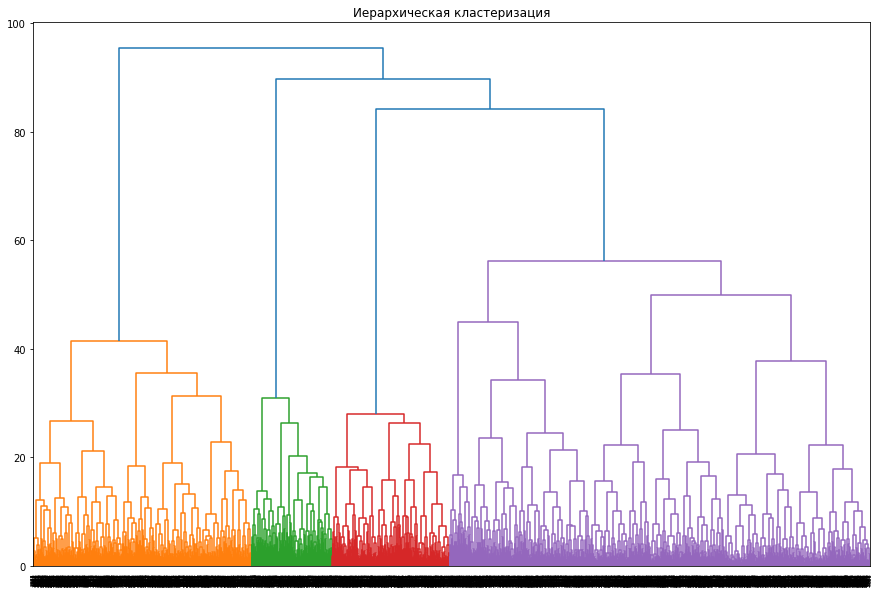

In [22]:
# обучение нормализатора и преобразование набора данных
x_sc = scaler.fit_transform(gym_churn.drop(columns = ['churn']))

# построение матрицы расстояний
linked = linkage(x_sc, method = 'ward')

# построение дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике. Для данного проекта будет взято 5 кластеров.

In [23]:
# число кластеров, равное 5, и фиксация значения random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0) 

# применение алгоритма к данным и формирование вектора кластеров
labels = km.fit_predict(x_sc) 

# сохранение меток кластера в поле датасета
gym_churn['cluster_km'] = labels

# вывод статистики по средним значениям признаков по кластеру
clusters = gym_churn.groupby(['cluster_km']).mean()
display(clusters)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster_km,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Для таких признаков как `gender`, `age`, `avg_additional_charges_total`, `lifetime`, `avg_class_frequency_total` и `churn` значения для большинства кластеров распределились равномерно, об этом говорят их близкие значения среднего. Но, например, для таких признаков как `near_location`, `partner`, `promo_friends`, `phone`, `contract_period` и `group_visits` значения распределены не равномерно по кластерам, особенно показательно для `near_location`, `phone` и `group_visits`, в одни кластеры попали данные, большинство значений которых равно нулю, что видно по среднему, а в другие попали данные, значение которых равно единице.

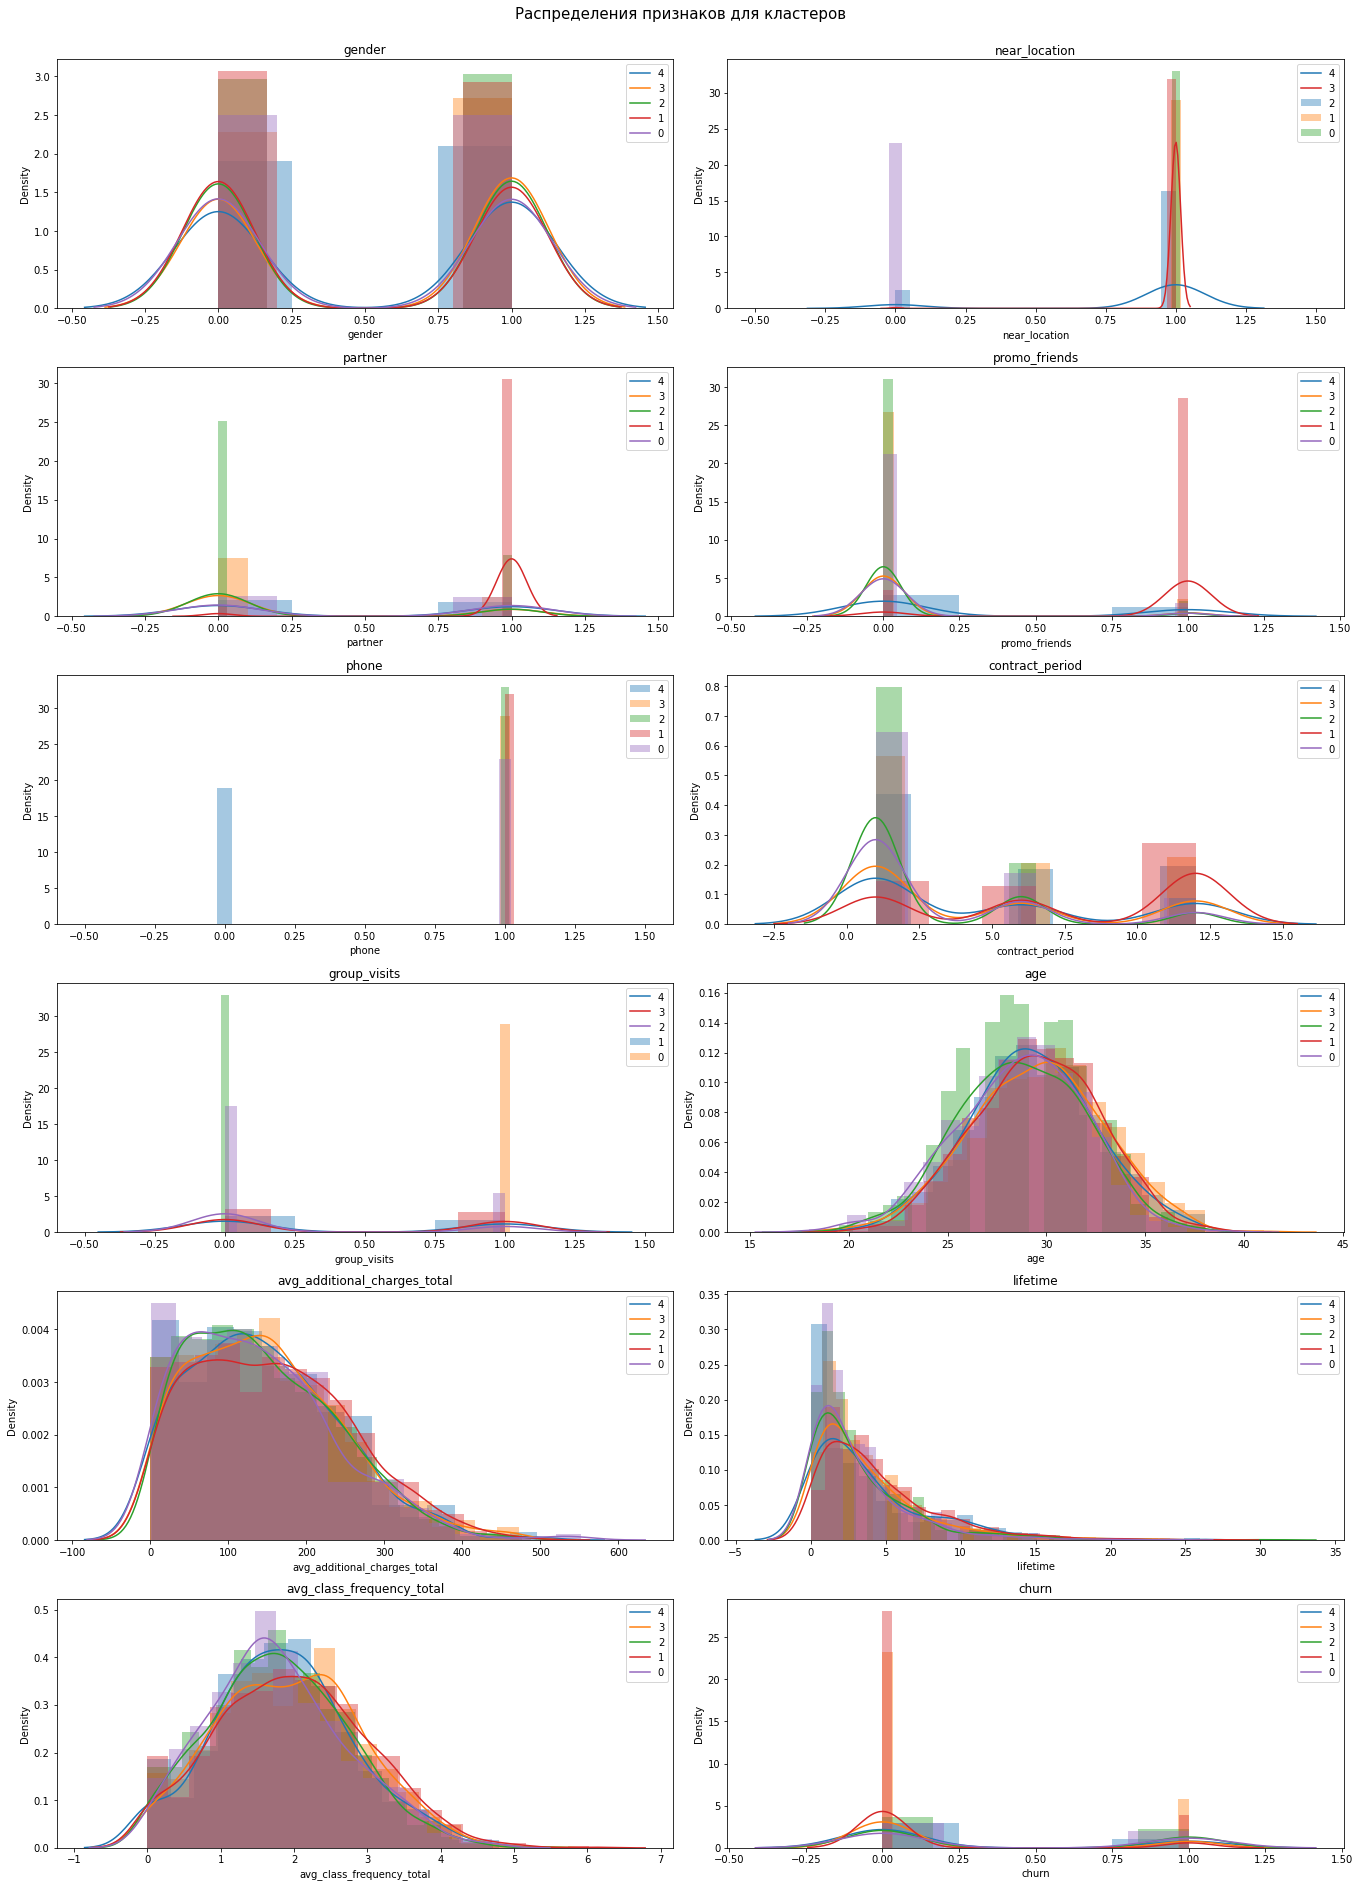

In [24]:
warnings.filterwarnings('ignore')

col_count, row_count = 2, 7
plt.figure(figsize = (19, 30))
params = gym_churn.columns.drop('cluster_km')

for i, param in enumerate(params):
    for cluster in gym_churn['cluster_km'].unique():
        sns.distplot(gym_churn[gym_churn['cluster_km'] == cluster][param], ax = plt.subplot(row_count, col_count, i+1))
    
    plt.title(param)
    
    plt.legend(labels=gym_churn['cluster_km'].unique())

plt.suptitle('Распределения признаков для кластеров', y = 1, fontsize = 15)

plt.tight_layout()

plt.show()

Для таких признаков как `gender`,  `age`, `avg_additional_charges_total`, `lifetime`, `avg_class_frequency_total` и `churn` значения для большинства кластеров распределились достаточно равномерно. Но, например, для таких признаков как `near_location`, `partner`, `promo_friends`, `phone` и `contract_period` значения распределены не равномерно по кластерам:
- `near_location` - большинство кластеров собрали значения факта проживания или работы в районе, где находится фитнес-центр, кроме 0-го;
- `partner` - для 0-го и 4-го кластеров значения распределились равномерно, 1-й кластер собрал в себе больше всего значений факта сотрудника компании-партнёра клуба, тогда как 2-й и 3-й напротив; 
- `promo_friends` - большинство кластеров собрали значения отрицательного факта первоначальной записи в рамках акции «приведи друга», кроме 1-го;
- `phone` - большинство кластеров собрали значения факта наличия контактного телефона, кроме 4-го;
- `contract_period` - большинство кластеров собрали значения по длительности текущего действующего абонемента равномерно, кроме 1-го (собрал в себе больше всего значений в год) и 2-го (собрал в себе больше всего значений в месяц);
- `group_visits` - большинство кластеров собрали значения по факту посещения групповых занятий равномерно, кроме 2-го(собрал в себе больше всего значений отрицательного факта посещения групповых занятий) и 0-го(собрал в себе больше всего значений факта посещения групповых занятий).

In [25]:
# группировка по cluster_km с подсчетом сетей
churn_per = (gym_churn.query('churn == 1').groupby('cluster_km').agg({'churn': 'count'}) / 
             gym_churn.groupby('cluster_km').agg({'churn': 'count'}))

display(churn_per)

,churn
cluster_km,
0,0.399287
1,0.120952
2,0.381625
3,0.200918
4,0.266839


По доле оттока кластеры 0 и 2 более склонны к оттоку, чем остальные. 1-й кластер является самым надежным, его доля оттока самая наименее вероятная.

**Вывод**

Исходя из средних значений и распределения признаков для класторов можно сделать вывод о том, что такие признаки как `gender`, `age`, `avg_additional_charges_total`, `lifetime`, `avg_class_frequency_total` и `churn` не оказывают влияния на разделение наблюдений на кластеры, а признаки `near_location`, `partner`, `promo_friends`, `phone`, `contract_period` и `group_visits` оказывают влияние и заставляют посетителей делиться на кластеры.

По доле оттока, самым надежным кластером оказался - 1-й. Кластеры 0 и 2 наиболее склонны к оттоку.

## Шаг 6. Выводы и базовые рекомендации по работе с клиентами

**Подготовка данных:**

В ходе подготовки данных было обнаружено и исправлено:

* Нарушение стиля в названиях столбцов - все названия столбцов были приведены к общему (нижнему) регистру;

Пропусков и дубликатов (явных, неявных) в данных не обнаружено.

**Исследовательский анализ данных (EDA):**

В ходе исследовательского анализа данных:
- В датафрейме 4000 наблюдений и 14 полей - 13 признаков и целевая переменная (`churn`). Признаки - численные;
- При построении графиков распределения параметров по оттоку - такие признаки как `gender`(пол) и `phone`(наличие контактного телефона) имеют одинаковый отток в случае клиентов разного пола, как и в случае наличия или нет контактного телефона, остальные признаки показывают больший отток: 
    - `near_location` - в случае не проживания или работы в районе, где находится фитнес-центр;
    - `partner` - в случае, если это не сотрудник компании-партнёра клуба;
    - `promo_friends` - в случае отсутствия факта первоначальной записи в рамках акции «приведи друга»;
    - `contract_period` - в случае длительности текущего действующего абонемента месяц и 6 месяцев;
    - `group_visits` - в случае отсутсвия факта посещения групповых занятий;
    - `age` - клиентов в возрасте до 30 лет;
    - `avg_additional_charges_total` - в случае суммарной выручки от других услуг фитнес-центра составляет менее 200 тыс. р.;
    - `month_to_end_contract` - в случае, когда срок до окончания текущего действующего абонемента составляет до 6 месяцев, особенно менее 2-х;
    - `lifetime` - в случае, когда с момента первого обращения в фитнес-центр прошло менее 4 месяцев, особенно менее 2-х;
    - `avg_class_frequency_total` - в случае, когда средняя частота посещений в неделю за все время с начала действия абонемента составляет менее 2-х раз;
    - `avg_class_frequency_current_month` - в случае, когда средняя частота посещений в неделю за предыдущий месяц составляет менее 2-х раз.
- По графику матрицы корреляций заметны две пары сильно коррелирующих признаков (более 0.8), `month_to_end_contract` - `contract_period` и `avg_class_frequency_current_month` - `avg_class_frequency_total`. Далее будут удалены по одному признаку из данных двух коррелирующих пар.
- При постоении диаграммы рассеяния признак-целевая переменная для каждого признака - ярких выбросов по диаграммам рассеяния - не наблюдается.  Перекос наблюдается в `lifetime`, но так как пропусков в данных не было и нулевые значения - реальные данные, то построение модели по ним - возможно. 

**Модель прогнозирования оттока клиентов:**

На основании метрик `Accuracy`, `Precision` и `Recall` модель LogisticRegression (Логистической регресси) показывает лучшие результаты в сравнении метрик модели DecisionTreeClassifier (Случайного леса).

**Кластеризация клиентов:**

Исходя из средних значений и распределения признаков для класторов можно сделать вывод о том, что такие признаки как `gender`, `age`, `avg_additional_charges_total`, `lifetime`, `avg_class_frequency_total` и `churn` не оказывают влияния на разделение наблюдений на кластеры, а признаки `near_location`, `partner`, `promo_friends`, `phone`, `contract_period` и `group_visits` оказывают влияние и заставляют посетителей делиться на кластеры.

По доле оттока, самым надежным кластером оказался - 1-й. Кластеры 0 и 2 наиболее склонны к оттоку.



***Исходя из признаков и оттока по ним, возможны следующие рекомендации:***
- `near_location` - удобное расположение в центре скопления офисов и жилых кварталов;
- `promo_friends` - увеличение информирования настоящих клиентов об акции «приведи друга»;
- `contract_period` - увеличение предложений и возможное введение акций на приобретение абониментов на год и более;
- `group_visits` - удобное время групповых занятий, с целью охвата большего числа посетителей;
- `avg_additional_charges_total` - введенее большего числа дополнительных услуг, пользующихся популярностью у посетителей, и специальных предложений для клиентов с абониментами длительностью в год;
- `month_to_end_contract` - увеличение предложений о продлении абонимента не позднее, чем за 3 месяца до его окончания.